In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.signal import butter, lfilter, freqz

%matplotlib inline

In [61]:
class BECTdetect(object):
    
    def __init__(self, num, S_size, threshold, template_mode="pdf", NAME="S-BECT", print_log=True):
        self.NAME = NAME
        self.num = num
        self.threshold = threshold
        self.print_log = print_log
        
        self.path = os.getcwd() + "\\test_csv_data\\" + self.NAME
        self.filename = os.listdir(self.path)[self.num-1]
        self.filepath = self.path + "\\" + self.filename
        self.data, self.label, self.columns = self._read_csv()
#         self.label_ind = np.array(np.where(self.label == 1)[0])
        self.s_channel = self.get_s_channel()
        self.s_data = self.data[self.s_channel]
        
        self.window = S_size
        self.template_mode = template_mode
        self.pdf_distribution = "gamma"
        if self.template_mode == "pdf":
            self._template = self._get_pdf_template()
        
        self.pred_ind, self.output = self._bect_detection()
        self.indicator = self.get_indicator()
        
        self._print_output()
            
    def _read_csv(self):
        raw_data = pd.read_csv(self.filepath)
        data = raw_data.drop(["label"], axis=1)
        label = raw_data["label"].values
        columns = raw_data.columns.values[:-1]
        if self.print_log:
            print("File loading: \""+self.filepath+"\".")
            print("The length of the data is "+str(data.shape[0])+".")
        return data, label, columns
    
    def get_s_channel(self):
        s_channels = self.filename[:-12].split("-")
        channel_name = []
        for name in self.columns:
            for s_channel in s_channels:
                if s_channel in name:
                    channel_name.append(name)
        if self.print_log:
            print("The labeled S-BECT channel is \"",channel_name,"\".")
        return channel_name
    
    def _print_output(self):
        print(" ")
        print("**********{:s}***********".format(self.filename))
        print("Signal Length-->{:d} s;".format(int(self.s_data.shape[0]/1000)))
        for channel in self.s_channel:
            print("Pred_S in channel \"{:s}\"-->{:d}; Indicator-->{:.2f}%.".format(channel, int(len(self.pred_ind[channel])), self.indicator[channel]*100))
        print("Max indicator-->{:.2f}%; ".format(max(self.indicator.values())*100))
        print("Avg indicator-->{:.2f}%; ".format(sum(self.indicator.values())/len(self.indicator)*100))
        return None
    
    def _get_pdf_template(self):
        
        # Use beta distribution
        if self.pdf_distribution == "beta":
            alpha=2
            beta=3.2
            x = np.linspace(0,1,self.window)
            pdf = stats.beta(alpha, beta).pdf(x)
        
        # Use gamma distribution
        elif self.pdf_distribution == "gamma":
            x = np.linspace(0,4,self.window)
            pdf = stats.gamma.pdf(x, a=2.2)
            pdf = pdf**2
        return pdf
    
    def _triang_spike(self, x):
        
        minx = np.min(x, axis=1)
        maxx = np.max(x, axis=1)
        out = np.zeros(x.shape)
        mid_ind = int(self.windows*1/3)
        out[:, :mid_ind] = np.linspace(minx, maxx, mid_ind, axis=1)
        out[:, mid_ind:] = np.linspace(maxx, minx, length-mid_ind, axis=1)
        return out
    
    def _pdf_spike(self, x):
        minx = np.min(x, axis=1)
        maxx = np.max(x, axis=1)
        
        pdf = self._template 
        pdf = (pdf-min(pdf))/(max(pdf)-min(pdf))
        pdf = np.tile(pdf, [x.shape[0], 1])
        out = (pdf.T*(maxx-minx)+minx).T
        return out
    
    def _bect_detection(self):
        detection_length = 1000

        All_channels_pred_ind = {}
        All_channels_filted_data = {}

        for channel in self.s_channel:
        
            data = np.array(self.s_data[channel])
            
            N = int(np.ceil(len(data)/detection_length))
            datas = np.array_split(data[:-(len(data)-(N-1)*detection_length)], N-1)
            rest = len(data)-(N-1)*detection_length
            
            if rest >= self.window:
                datas = datas + [data[-(len(data)-(N-1)*detection_length):]]
                
            filted_data = np.zeros(data.shape)
            pred_ind = []   
            
            i = 0
            for x in datas:
                xx = self._window_slide(x)
                if self.template_mode == "pdf":
                    template = self._pdf_spike(xx)
                elif self.tmplate_mode == "triang":
                    template = self._triang_spike(xx)
                score = np.mean(xx*template, axis=1)
                expanded_score = np.hstack([np.zeros(int(self.window/2)), score, np.zeros(self.window-int(self.window/2)-1)])
                if i<len(datas)-1:
                    filted_data[i*x.shape[0]:(i+1)*x.shape[0]] = expanded_score
                else:
                    filted_data[-(len(datas)-i)*x.shape[0]:] = expanded_score

                outline_ind, flag, s= self._find_S_points(score)
                print(np.floor(i/5),"-->",flag, s)
                if len(outline_ind) > 0:
                    outline_ind += i * detection_length
                    pred_ind = pred_ind + list(outline_ind)
                i += 1
            pred_ind = np.array(pred_ind)
            All_channels_pred_ind[channel] = pred_ind
            All_channels_filted_data[channel] = filted_data

        return All_channels_pred_ind, All_channels_filted_data
    
    def _window_slide(self, x):
        stride = 1
        n = int((len(x)-(self.window-stride))/stride)
        out = np.zeros((n, self.window))
        for i in range(self.window-1):
            out[:,i] = x[i:-(self.window-1-i)]
        out = (out.T - np.mean(out, axis=1)).T
        return out
    
    def _find_S_points(self, score):
        dscore = score[1:]-score[:-1]
        
        peak_ind = np.where(dscore[:-1]*dscore[1:]<0)[0]
        peak_score = score[peak_ind]
        flag = 0
        
        if np.std(peak_score) < 220:
            outline_ind = []
        else:
            flag_score = (score - min(score))/(max(score)-min(score))-0.5
#             peak_ind_0 = [ind for i, ind in enumerate(peak_ind) if i%2==0]
#             peak_ind_1 = [ind for i, ind in enumerate(peak_ind) if i%2==1]
#             if len(peak_ind_0) > len(peak_ind_1):
#                 peak_ind_0 = peak_ind_0[:-1]
#             elif len(peak_ind_1) > len(peak_ind_0):
#                 peak_ind_1 = peak_ind_1[:-1]
#             assert(len(peak_ind_0)==len(peak_ind_1))
#             delta = np.abs(flag_score[peak_ind_1] - flag_score[peak_ind_0])
            delta = np.abs(flag_score[peak_ind[1:]] - flag_score[peak_ind[:-1]])
            delta = delta[np.where(delta < 0.8)[0]]
            flag = np.sum(delta) 

            if flag > 4.0:
                outline_ind = []
            else:
                n = self.threshold
                mean = np.mean(peak_score)
                std = np.std(peak_score)
                ind = np.where(abs(peak_score-mean)>n*std)[0]
                outline_ind = peak_ind[ind]
                ind = np.where(score[outline_ind]>0)[0]
                outline_ind = outline_ind[ind]
                outline_ind += int(self.window/2)
        return outline_ind, flag, np.std(peak_score)
        
    def get_indicator(self):

        window = 1000
        indicator = {}
        for channel in self.s_channel:
            length = self.s_data.shape[0]
            mask = np.zeros(length)
            mask[self.pred_ind[channel]] = 1
            N = int(length/window)
            rest = length%window
            mask = mask[:-rest]
            rest = mask[-rest:]
            split = mask.reshape(N, window)
            out = np.zeros(N+1)
            out[:N] = split.sum(axis=1)
            out[-1] = sum(rest)
            indicator[channel] = 1-(len(np.where(out==0)[0])/len(out))

        return indicator

    # def get_indicator(self):
    #     split_length = self.pred_ind[1:]-self.pred_ind[:-1]
    #     long_split_length = split_length[np.where(split_length>=2000)[0]]
    #     long_split_second = np.floor(long_split_length/1000)
    #     indicator = 1-(np.sum(long_split_second)*1000/len(self.s_data))
    #     return indicator
    
    def plot_result(self, slice_ind=None):
        if slice_ind == None:
            size = [0, len(self.s_data)-1]
        else:
            if slice_ind[1] > len(self.s_data)-1:
                slice_ind[1] = len(self.s_data)-1
            size = [slice_ind[0], slice_ind[1]]
        
        channel_num = len(self.s_channel)
        
        plt.figure(figsize=[15,3*channel_num])
        i = 0
        for channel in self.s_channel:
            i += 1
            plt.subplot(2*channel_num,1,i)
            plt.plot(self.s_data[channel][size[0]:size[1]], linewidth="1")
            plt.title("Signal of "+channel+" channel")
            
            i += 1
            plt.subplot(2*channel_num,1,i)
            plt.plot(np.arange(size[0],size[1]),self.output[channel][size[0]:size[1]])
            plt.title("Detection")
            for ind in self.pred_ind[channel]:
                if ind>=size[0] and ind<=size[1]:
                    plt.axvline(ind, c="g")
        plt.tight_layout()
        return None
    
    def plot_deep_image(self, slice_ind=None):
        if slice_ind == None:
            size = [0, len(self.s_data)-1]
        else:
            if slice_ind[1] > len(self.s_data)-1:
                slice_ind[1] = len(self.s_data)-1
            size = [slice_ind[0], slice_ind[1]]
        
        channel_num = len(self.s_channel)
        
        plt.figure(figsize=[15,3*channel_num])
        i = 0
        for channel in self.s_channel:
            i += 1
            plt.subplot(channel_num,1,i)
            x = np.array(self.s_data[channel][size[0]:size[1]])
            x = x.reshape(-1, 1)
            x = np.concatenate([-(x-xi) for xi in x], axis=1)
            y1 = np.triu(x)
            y2 = -np.tril(x)
            y3 = np.eye(len(x))*x
            x = y1+y2+y3
            plt.imshow(x)
            plt.title("Signal of "+channel+" channel")
        plt.tight_layout()
        return None
        

File loading: "C:\Users\yyy96\Documents\VScodework\EEG_detection\test_csv_data\S-BECT\C3-zxy-001.csv".
The length of the data is 1142626.
The labeled S-BECT channel is " ['C3-Av'] ".
0.0 --> 1.9964694976377932 293.9790083857672
0.0 --> 3.099244488088569 1573.4745861657082
0.0 --> 2.713806833305099 1659.4117658313642
0.0 --> 3.5572576663415236 500.09535832488484
0.0 --> 2.733941086465576 1708.2745242698172
1.0 --> 3.651715425433554 1503.0624453496487
1.0 --> 2.142310917787686 1447.6082642578433
1.0 --> 4.312248773923315 725.8013454603185
1.0 --> 2.8707934035233102 1171.4438270763583
1.0 --> 1.8077837797040015 1105.7546361376812
2.0 --> 2.4401737166558117 932.0347604076875
2.0 --> 4.561320994605831 1421.7202276342077
2.0 --> 1.0731502825721226 971.4834026595576
2.0 --> 4.641121591192198 1528.0898519318591
2.0 --> 1.6385240723442849 2117.876498655614
3.0 --> 2.7344967178969757 1015.195312547502
3.0 --> 3.4758381064492663 1604.4859043715721
3.0 --> 2.5543453705965637 941.7033078817643
3.0 

48.0 --> 3.26556673389781 724.7213083221641
48.0 --> 1.7577032207344538 1562.2865914626548
49.0 --> 1.975880160874604 1391.827241034069
49.0 --> 1.9071693271834476 1075.3175609317182
49.0 --> 3.377054835904686 1481.267284060033
49.0 --> 3.45522041478469 1477.444934444503
49.0 --> 5.156687983620076 2086.7067199381704
50.0 --> 2.5570015736272786 1501.7280648328845
50.0 --> 1.5901029875859234 1571.0259068717246
50.0 --> 1.7716875293731371 982.2867985253868
50.0 --> 1.7038485300591568 1926.2048469438926
50.0 --> 3.6378903399620075 819.0922624635399
51.0 --> 0.8229221276761415 315.50619124286715
51.0 --> 2.0752256573878785 940.9758388962875
51.0 --> 3.6129832697380766 863.3370451499824
51.0 --> 1.2495966885908976 552.6062316006713
51.0 --> 2.6215687869805984 600.0959181210184
52.0 --> 1.7734935829362914 2330.723603450337
52.0 --> 2.584944168502667 938.2152727334685
52.0 --> 2.171619027877895 401.34158884255396
52.0 --> 1.3414985170953262 454.22109010100473
52.0 --> 0 96.34546032767483
53.0 

101.0 --> 2.4960232686556756 1557.5204129261215
102.0 --> 1.4745706913248242 1071.1795586241096
102.0 --> 0.9492925047275003 1746.0693336122517
102.0 --> 3.4283042506397523 1537.1530373663843
102.0 --> 2.095340442580728 694.026520618188
102.0 --> 1.6730474693172281 292.0493584918806
103.0 --> 1.1374435241518934 1324.8547882269302
103.0 --> 3.381172015983929 611.5830475341753
103.0 --> 1.725560120293828 597.8832990171192
103.0 --> 4.184751639927431 1302.4799835586334
103.0 --> 1.9542109013419973 1443.840316498782
104.0 --> 1.8133871081459367 1887.9814657321165
104.0 --> 0 95.05628954281019
104.0 --> 3.5451878527947107 1856.7499853486872
104.0 --> 3.1033944538241696 452.6573387057627
104.0 --> 1.6435506312876627 424.4752936889875
105.0 --> 2.339360653662076 870.9562027254392
105.0 --> 3.4758781190518704 389.60074052433964
105.0 --> 3.506385671256837 1478.3760994302606
105.0 --> 0 103.65766147528569
105.0 --> 3.9927826102033173 1041.441934898314
106.0 --> 2.107574912383216 1176.5622950148

151.0 --> 2.84670410244087 912.1492083578953
151.0 --> 1.3224252773290581 254.65491066263883
151.0 --> 3.073179866848635 462.0503154811267
151.0 --> 1.8769029412377292 1465.0511463372843
151.0 --> 3.1027018601817815 1793.8338553768838
152.0 --> 1.2373541061702809 1394.1735319485613
152.0 --> 4.585815689113739 755.3288439802932
152.0 --> 5.515410727965765 1931.7647964789612
152.0 --> 0.7074424774088208 604.1872001546719
152.0 --> 2.584923521653058 861.2404829966453
153.0 --> 3.1014721387893234 1479.8167542830106
153.0 --> 0.7809007975710509 497.3855130048122
153.0 --> 2.1966365483381174 658.5411142412299
153.0 --> 0.9633627122635092 1300.7198134261212
153.0 --> 1.8791733047605401 853.9678989238332
154.0 --> 4.063026530792652 715.349813118889
154.0 --> 2.8671120649755935 613.2873539328248
154.0 --> 0 86.01240549987789
154.0 --> 1.9269386457785538 638.086772222745
154.0 --> 3.0773638466856275 851.1035319425915
155.0 --> 5.286148470061352 282.46399281003744
155.0 --> 3.303396119920646 318.

205.0 --> 1.1675478323017594 399.1444658646451
205.0 --> 3.405591489303498 819.145183410006
205.0 --> 0 198.35299690031354
205.0 --> 1.8752400924766839 1669.7661187310287
205.0 --> 2.3708684897710244 404.36294602143437
206.0 --> 2.2095519470596185 1213.2184728732425
206.0 --> 3.5506276809143738 1710.7545317469167
206.0 --> 1.3327255436054886 1868.5768751084106
206.0 --> 2.7906768113169997 1790.0964089179843
206.0 --> 1.6241997228617489 1574.260454995151
207.0 --> 1.4923160035855472 1365.4518389007897
207.0 --> 3.2112895899265057 1549.5415843035446
207.0 --> 0 81.22251498597085
207.0 --> 3.0864216203861385 624.2085396301064
207.0 --> 1.7592582785235045 1312.7515289706025
208.0 --> 3.7969392846933916 849.4660654635903
208.0 --> 1.5542267334640323 1061.4503070157743
208.0 --> 1.6905532623475596 989.4736559440189
208.0 --> 2.7585931800900947 1270.3103044070433
208.0 --> 3.7425281412654927 668.2821893194738
209.0 --> 2.2486971521176065 674.3760565953226
209.0 --> 1.8108796212279443 415.6811

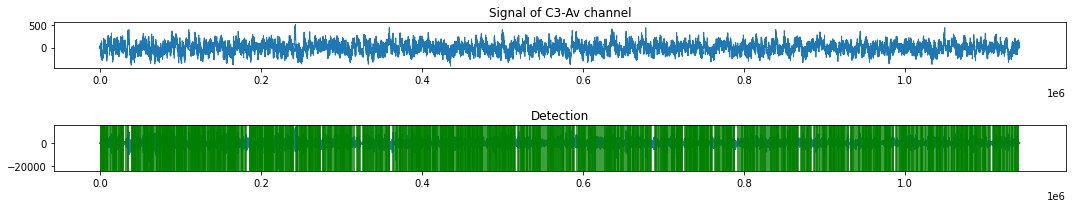

In [62]:
bect = BECTdetect(num=4, S_size=61, threshold=2)
bect.plot_result()

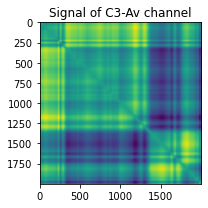

In [69]:
i = 15
bect.plot_deep_image([i*2000,(i+1)*2000])

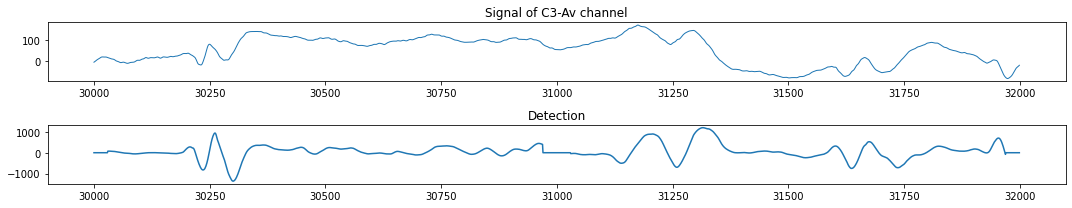

In [70]:
# i = 5,6,7,8,9,19,22,23
bect.plot_result([i*2000,(i+1)*2000])

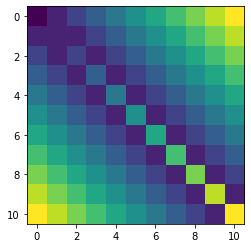

In [71]:
x = np.array([0,1,2,3,4,5,6,7,8,9,10])
x = x.reshape(-1,1)
y = np.concatenate([-(x-xi) for xi in x], axis=1)
y1 = np.triu(y)
y2 = -np.tril(y)
y3 = np.eye(len(x))*x
y = y1+y2+y3
plt.imshow(y)